<h1>Project Description</h1><br>
The purpose of this project is to:
<ul>
<li>See the popularity of Trump's tweets across countries</li>
<li>Perform a sentiment analysis of recent tweets by Trump across countries</li>
<li>See if similar reactions occur if his tweets are talking about the same topic</li>
</ul>

<h1>Data Collection</h1>

We utilised the several datasets available at https://github.com/bpb27/trump_tweet_data_archive which happens to automatically updata Trump's tweets every hour. All of the datasets are saved in json format and the data contained in them is the result of calls to the Twitter API. There are two varients, <b>master</b> which contains all of the original information from the API call and <b>condensed</b> which contains a lot less but essential information. After looking through some of the master and condensed datasets, we decided that the condensed datasets were sufficient as they contained the specfic fields we required (such as ...?) and the entries in master were unnecessarily large for our purpose (too much information that we would not use). <br>

We're using all of the condensed datasets from 2009 to 2017 because the tweet data isn't that time consuming to process and having as much data as possible will be beneficial when clustering the messages in the tweets. Since the 2017 datatset is continiously being updated, we are only using it up to a certain date (--/--/2017). All of the data in total is around 10 MB so it is really simple to handle and there is no need to rely on additional computing resources<br>

Below, we import all the necessary libraries we need for extracting and combining the data. We iterate over each json file and turn them into a pandas DataFrame and store them in the list <b>data</b>. We do this so that later on we can simply combine them into one single dataframe.

In [73]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

In [74]:
#Create empty list to store all of our data
data=[]

#Add data from 2009 to 2017
data.append(pd.DataFrame(json.load(open("data/condensed_2009.json"))))
for i in range(10,17):
    fileName="data/condensed_20"+str(i)+".json"
    data.append(pd.DataFrame(json.load(open(fileName))))

Next, we combine all of our seperate datasets into one pandas dataframe. We also set the id of the dataframe to <b>id_str</b> since we already know that each of the ids are unique. we also have to convert the <b>created_at</b> attribute into a Date object so that the dataframe is able to properly sort tweets by date (if it was still a string then it would sort incorrectly as it would put tweets starting on a Friday first.

In [75]:
#Combine all of the individual datasets together
df = pd.concat(data)

#Set the index
df = df.set_index("id_str")

#Convert to Date
df["created_at"]=pd.to_datetime(df["created_at"])

In [76]:
df.sort_values("created_at",inplace=True)
df

,created_at,favorite_count,in_reply_to_user_id_str,is_retweet,retweet_count,source,text
id_str,,,,,,,
1698308935,2009-05-04 18:54:25,202,None,False,253,Twitter Web Client,Be sure to tune in and watch Donald Trump on L...
1701461182,2009-05-05 01:00:10,3,None,False,2,Twitter Web Client,Donald Trump will be appearing on The View tom...
1737479987,2009-05-08 13:38:08,2,None,False,3,Twitter Web Client,Donald Trump reads Top Ten Financial Tips on L...
1741160716,2009-05-08 20:40:15,27,None,False,8,Twitter Web Client,New Blog Post: Celebrity Apprentice Finale and...
1773561338,2009-05-12 14:07:28,1950,None,False,1421,Twitter Web Client,"""My persona will never be that of a wallflower..."
1776419923,2009-05-12 19:21:55,13,None,False,10,Twitter Web Client,"Miss USA Tara Conner will not be fired - ""I've..."
1786560616,2009-05-13 17:38:28,10,None,False,11,Twitter Web Client,Listen to an interview with Donald Trump discu...
1796477499,2009-05-14 16:30:40,6,None,False,3,Twitter Web Client,"""Strive for wholeness and keep your sense of w..."
1806258917,2009-05-15 14:13:13,2,None,False,1,Twitter Web Client,"Enter the ""Think Like A Champion"" signed book ..."


<h1>Analyzing the data</h1><br>

<h2>Attributes in the data</h2>

What does the data look like ? In each json file, there is an array where each element represents
a seperate tweet. In each array element, the following information can be found:<br>

<ul>
<li><b>created_at:</b> (string) the date the tweet was posted<br></li>
<li><b>favourite_count:</b> (integer) represents the number of individual users that liked this post<br></li>
<li><b>id_str:</b> (string) a unique string id for this tweet provided by the API<br></li>
<li><b>in_reply_to_user_id_str:</b> (string) the string id of a tweet that this tweet is a reply to<br></li>
<li><b>is_retweet:</b> (boolean) True if this tweet is a retweet of another tweet <br></li>
<li><b>retweet_count:</b> (integer) an integer representing the amount of times this tweet was retweeted<br></li>
<li><b>source:</b> (string/categorical) the type of device this tweet was posted from (for example a desktop or phone)<br></li>
<li><b>text:</b> (string) the actual text from this tweet<br></li>
</ul>


To see all of the possible values of <b>source</b>, we simply use the following line:

In [77]:
df["source"].unique()

array(['Twitter Web Client', 'TweetDeck', 'TwitLonger Beta', 'Facebook',
       'Twitter for iPhone', 'Mobile Web (M5)', 'Twitter for Android',
       'Instagram', 'Twitlonger', 'Vine - Make a Scene',
       'Twitter for Websites', 'Twitter for BlackBerry',
       'Neatly For BlackBerry 10', 'Periscope', 'Twitter QandA',
       'Twitter Mirror for iPad', 'Twitter Ads', 'Twitter for iPad',
       'Media Studio'], dtype=object)

<b>favourite_count</b> and <b>retweet_count</b> are both positive integers

Below is an example of what 1 entry may look like

In [78]:
df.iloc[0]

created_at                                               2009-05-04 18:54:25
favorite_count                                                           202
in_reply_to_user_id_str                                                 None
is_retweet                                                             False
retweet_count                                                            253
source                                                    Twitter Web Client
text                       Be sure to tune in and watch Donald Trump on L...
Name: 1698308935, dtype: object

One important thing to be noted about twitter for those who are unfamiliar, a retweet is essentially where you take someone else's tweet and post that to your twitter feed where as a reply is a tweet that is directly aimed at an existing tweet. 

What we can see from the dataset above is that not all of the information we need is there. For example to do a proper sentiment analysis of people reacting to Trump, we need to look at the replies of these people. For that we need an external library such as ... ??? Also, we need to see what country those replies originated from. This can be done using the twitter API since the API calls contain more extensive information such as geolocation of the tweet's origin. 

If we take a look at the tweets themselves, we see that there is certain symbols and text that we can remove as they don't contribute to our clustering of topics. For example, a lot of tweets contain external http links. Also, twitter happens to encode the & symbol as the string &amp so these need to be converted. 


<h2>Computing statistical information</h2>

Using the describe function below, we can see that there are 30192 tweets in our total dataset. Only two of the features can have these values computed because the rest are strings or booleans. 

In [119]:
df.describe()

,favorite_count,retweet_count
count,30192.000000,30192.000000
mean,3385.386228,1363.948198
std,12319.745232,4813.511737
min,0.000000,0.000000
25%,19.000000,15.000000
50%,58.000000,74.000000
75%,773.750000,684.250000
max,633253.000000,344806.000000


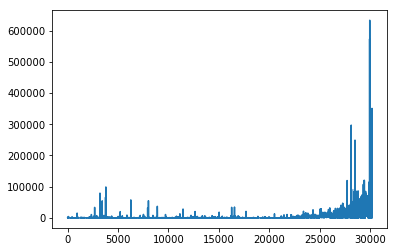

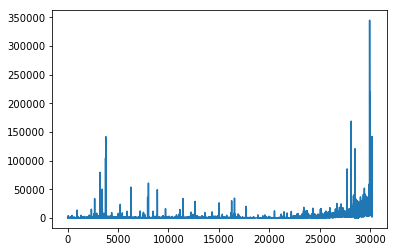

In [123]:
plt.plot(list(df["favorite_count"]))
plt.show()
plt.plot(list(df["retweet_count"]))
plt.show()

<h2>Checking for missing values</h2>

We will now check to see if there are potentially any values missing at all. Note that we don't consider a value of None in <b>in_reply_to_user_id_str</b> to be a missing value as it's acceptable for a tweet to not reply to another. We make a copy of our original dataframe, drop the in_reply_to_user_id_str (because pandas think's that the value None is a null value in this case) and then do a query to return all entries with some form of missing value. As we can see, we get no entries in this case so all of the values are present.

In [79]:
dfNull=df.copy()
dfNull=dfNull.drop("in_reply_to_user_id_str",axis=1)
dfNull[dfNull.isnull().any(axis=1)]

,created_at,favorite_count,is_retweet,retweet_count,source,text
id_str,,,,,,


<h2>Correlations between features</h2>

Next we want to analyze the correlations between the different fields. It doesn't make sense to look at correlations between string fields and the rest as the strings can take on a large range of values that aren't repeated often. However we can convert the categorical strings into integers as they occur frequently. We create a copy of the dataframe and then create a dictionary to have a mapping from a <b>source</b> value to an integer. Then we alter all of the rows in this datafram to have these integer values.

In [99]:
dfCorr=df.copy()

keys=dfCorr["source"].unique()
values=list(range(len(keys)))
dictionary = dict(zip(keys, values))

for i in range(len(dfCorr)):    
    s=dfCorr.iloc[i]["source"]
    dfCorr.iloc[i, dfCorr.columns.get_loc('source')] = int(dictionary.get(s))
    
dfCorr["source"] = dfCorr["source"].astype('int64')

In [109]:
dfCorr.dtypes

created_at                 datetime64[ns]
favorite_count                      int64
in_reply_to_user_id_str            object
is_retweet                           bool
retweet_count                       int64
source                              int64
text                               object
dtype: object

Below is a correlation matrix between all of the integer values as well as 

In [115]:
corrMatr=dfCorr.corr(method='pearson', min_periods=1)
corrMatr

,favorite_count,is_retweet,retweet_count,source
favorite_count,1.000000,-0.021752,0.916265,0.134390
is_retweet,-0.021752,1.000000,0.084379,-0.002959
retweet_count,0.916265,0.084379,1.000000,0.100975
source,0.134390,-0.002959,0.100975,1.000000


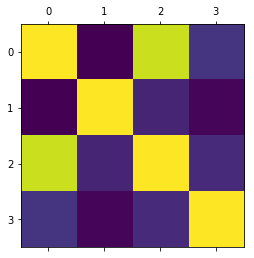

In [114]:
plt.matshow(corrMatr)
plt.show()

To interpret the matrix, yellow is for 100% correlation (when a variable correlates to itself), the more darker colours represent less correlation and the green one show that there is a relatively high correlation (>90%). What we see is that for Trump's tweets, the <b>favorite_count</b> and <b>retweet_count</b> are highly correlated. The relations between the other variables are quite low (from -0.021752 to 0.134390)

<h1>Text Cleaning</h1>

In [6]:
'''
Text cleaning

In the text we can see that the ampersand symbol & is often encoded as &amp; so we need to replace all occurences of this
We can also remove http links for now as they are not really contributing to a sentiment analysis

We should exctract hashtags as they reveal something important, can put them in a new column where each entry is a list ?

Remove \n characters 
'''

#Given a text t, returns all hashtags as a list
def GetHashtags(t):
    hashtags=[]
    splitText=text.split(" ")
    for s in splitText:
        if("#" in s):
            hashtags.append(s)
    return hashtags

#    i=242
for i in range(len(df)):
    text=df.iloc[i]["text"]
    text=text.replace("&amp;","&")
    text=text.replace("\n;","")
    
    text=" ".join(text.split("\n"))

    text=text.split("https",1)[0]   
    
    
    hashtags=GetHashtags(text)
    df.set_value(i,"text",text)




In [8]:
#Should we use lower case of texts here ?.lower()
def CreateDictionary(df):
    textDict={}
    for i in range(len(df)):
        t=df.iloc[i]["text"]
        splitT=t.split(" ")
        for s in splitT:
            if(textDict.get(s)==None):
                textDict[s]=1
            else:
                textDict[s]+=1
    return textDict
            
textDict=CreateDictionary(df)

In [88]:
trumpDict=pd.DataFrame.from_dict(list(textDict.items()))
trumpDict.rename(columns={0:"words",1:"occurences"},inplace=True)
trumpDict.sort_values("occurences",ascending=False,inplace=True)


#DF of all hashtags
trumpDict[trumpDict["words"].str.contains("#")].head()


NameError: name 'textDict' is not defined

## Sentiment Analysis

In [ ]:
from aylienapiclient import textapi
import csv
import time
client = textapi.Client("9a0daca1", "62fbf9df3887a46f0e59e3815a958b6a")
sentiment = client.Sentiment({'text': "Make America Great Again!"})
print(sentiment)

In [ ]:
def analyse(tweet):
    text = tweet['text'].strip()
    sleepTime = 4
    if len(text) == 0:
        print('** skipped')
        return None
    while(True):
        try:
            sentiment = client.Sentiment({'text': text})
            sentiment['id'] = tweet.name
            print(text)
            return sentiment
        except:
            print("Sleeping... (time:", sleepTime, ")")
            time.sleep(sleepTime)
            sleepTime *= 2

def analyseTweets(df, batch_size=100):
    i = 0
    sentiments = pd.DataFrame()
    while(i <= len(df)):
        batch = df[i:(i + batch_size)].apply(analyse, axis=1).tolist()
        t0 = time.time()
        new = pd.DataFrame(batch).set_index('id')
        t1 = time.time()
        print("DataFrame(): %f" % (t1 - t0))
        t0 = time.time()
        sentiments = sentiments.append(new)
        t1 = time.time()
        print("tolist(): %f" % (t1 - t0))
        time.sleep(batch_size // 10)
        i += batch_size
        print("Tweets analysed:", i)
    return sentiments

sentiments = analyseTweets(df)
sentiments.to_csv('sentiments.csv')

## Clustering

In [10]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Michele\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from stop_words import get_stop_words
from gensim import corpora, models
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
%pylab inline
import re

In [186]:
def preProcess_procedure(tweet):
    original = tweet
    tweet = re.sub(r'([a-z]+)\.([A-Z].+)', '\1 \2', tweet)
    tweet = tweet.lower()
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    tweet = re.sub(r'(\d+[:\/,\.])+\d+ *([ap]\.?m\.?)?', '', tweet)
    tokenizer = RegexpTokenizer(r'[a-z_@#][a-z0-9_\'\.]+[a-z0-9_]')
    tweet = tokenizer.tokenize(tweet)
    stopwords = get_stop_words('en')
    stopwords.append('amp')
    p_stemmer = PorterStemmer()
    tweet = [i for i in tweet if not i in stopwords]
    tweet = [p_stemmer.stem(i) for i in tweet]
    #print(original, "=>", tweet)
    return tweet
    
def preProcess(tweets, ratio=0.8):
    tweets.index = range(len(tweets))
    indices = np.random.permutation(tweets.index)
    train_len = int(len(tweets) * ratio)
    train_indices = indices[:train_len]
    test_indices = indices[train_len:]
    orig_test = tweets[test_indices]
    tweets = tweets.map(preProcess_procedure)
    dictionary = corpora.Dictionary(tweets)
    train = [dictionary.doc2bow(tweets[tweet]) for tweet in train_indices]
    test = [dictionary.doc2bow(tweets[tweet]) for tweet in test_indices]
    return train, test, orig_test, dictionary
    
train, ltest, orig_test, dictionary = preProcess(df['text'])

Populating the interactive namespace from numpy and matplotlib


In [188]:
lda = models.ldamodel.LdaModel(train, num_topics=100, id2word = dictionary, passes=20)    

In [189]:
lda[ltest[0]]

[(5, 0.087011069276328304),
 (13, 0.078425979578402888),
 (45, 0.15890383503589151),
 (58, 0.081821932311887863),
 (66, 0.077692307692307783),
 (68, 0.077692307692307797),
 (88, 0.18463838829626922),
 (98, 0.18304494934737511)]

In [190]:
# Show Clustering
i = 0
for tweet in ltest:
    print(orig_test.iloc[i], "\n")
    print(sorted(lda[tweet], key=lambda tup: tup[1], reverse=True), "\n")
    i += 1

The only reason irrelevant @GlennBeck doesn't like me is I refused to do his failing show - asked many times. Very few listeners - sad! 

[(88, 0.18369019200163286), (98, 0.18203863108781387), (45, 0.15894311469867156), (5, 0.087092543989981799), (58, 0.083656030856378238), (13, 0.078425641211676514), (68, 0.077692307692307797), (66, 0.077692307692307783)] 

Carly Fiorina- I agree! Ted Cruz is just another politician. All talk- no action!  

[(79, 0.24600823209419964), (73, 0.21035540426943744), (16, 0.18272727272727302), (57, 0.18272727272727302), (29, 0.091818181818181951)] 

"@truthinvest: @CNN @tedcruz @realDonaldTrump Ted Cruz is the definition of sleaze. Just ask @RealBenCarson" 

[(18, 0.41411437350396241), (73, 0.19553768918632536), (63, 0.12240966512653284), (36, 0.094613094571700931), (57, 0.094158510944813062)] 

"@becker_berta: @vivhall3 @Reince Millions more will burn their Republican registration if GOP continues to subvert the will of the people." 

[(71, 0.2999379176882


Why does @megynkelly devote so much time on her shows to me, almost always negative?  Without me her ratings would tank. Get a life Megyn! 

[(63, 0.33235470792467814), (83, 0.13400000000000015), (69, 0.13047773129171322), (66, 0.070855602041620336), (42, 0.068978625408655611), (24, 0.067333333333333412), (8, 0.067333333333333398), (14, 0.067333333333333398)] 

Crooked Hillary is spending tremendous amounts of Wall Street money on false ads against me. She is a very dishonest person! 

[(8, 0.24831543273640511), (55, 0.19071588870122183), (28, 0.15461538461538482), (48, 0.15461538461538482), (98, 0.10173790933160455), (26, 0.077692307692307797)] 

"Donald Trump retains national lead in new ABC News/WaPo poll with 37%:  

[(58, 0.25712947345391141), (77, 0.18255335486213425), (88, 0.11125569184379479), (73, 0.10832507200063428), (59, 0.091992099683320477), (13, 0.091818181818181896), (55, 0.072380671792569032)] 

Just saw Crooked Hillary and Tim Kaine together. ISIS and our other enemi

The Club For Growth said in their ad that 465 delegates (Cruz) plus 143 delegates (Kasich) is more than my 739 delegates. Try again! 

[(96, 0.36047160810395551), (8, 0.30379248339231879), (90, 0.095892028259681628), (51, 0.091818181818181979), (95, 0.061662062062227227)] 

RT @DanScavino: WE LOVE OUR DEPLORABLES!!! #TrumpTrain #Debates2016  

[(26, 0.33500000000000107), (6, 0.33499999996965008), (20, 0.16833333333333389)] 

Thank you Sanford, Florida. Get out &amp; VOTE #TrumpPence16! #ICYMI- watch this afternoons rally here:… https://t.co/zVXrScClfd 

[(65, 0.34106141257976696), (49, 0.22499383760338751), (17, 0.12728339457483556), (56, 0.11458680393219833), (2, 0.10571091494617678)] 

@elizabethforma Goofy Elizabeth Warren, sometimes referred to as Pocahontas because she faked the fact she is native American, is a lowlife! 

[(0, 0.61358131565205631), (9, 0.15461538461538485), (12, 0.080264838194098589), (85, 0.077692307692307838)] 

The rules DID CHANGE in Colorado shortly after I 

Thank you Michigan. This is a MOVEMENT. We are going to MAKE AMERICA SAFE AND GREAT AGAIN! #TrumpPence16  

[(43, 0.57242565170356574), (65, 0.11802095610925042), (74, 0.11255339218718466), (56, 0.10100000000000009)] 

.@Macys was one of the worst performing stocks on the S&P last year, plunging 46%. Very disloyal company. Another win for Trump! Boycott. 

[(64, 0.16360912005893516), (5, 0.15617135995948869), (57, 0.082918381424627818), (75, 0.079890807008859366), (4, 0.079495340904791253), (39, 0.077931436997317763), (76, 0.077757618997399802), (15, 0.075980988253285711), (38, 0.073558215646842742), (77, 0.072686730748453027)] 

Heading now to Pella, Iowa. Big crowd! Remember, Trump is a big buyer of Pella windows. See you soon! 

[(83, 0.24246305266587195), (71, 0.21642976432561548), (0, 0.20066666666666694), (1, 0.07644051634184662), (49, 0.076236789068776706), (77, 0.067333333333333426), (34, 0.058429877597890159)] 

'It's just a 2-point race, Clinton 38%, Trump 36%'  

[(18, 0.254


The failing @nytimes talks about anonymous sources and meetings that never happened. Their reporting is fiction. The media protects Hillary! 

[(98, 0.39069966742828804), (16, 0.15703636249808961), (48, 0.1483445038822197), (84, 0.079465672018221384), (4, 0.079055352878126525), (39, 0.078255584152198784)] 

Basically nothing Hillary has said about her secret server has been true. #CrookedHillary 

[(36, 0.33444444444444493), (48, 0.22333333333333361), (72, 0.1122222222222224), (39, 0.11222222222222238), (55, 0.11222222222222238)] 

Join me! #Trump2016  6/10: Richmond  

[(23, 0.252500000000001), (56, 0.252500000000001), (21, 0.25250000000000095)] 

'CNBC, Time magazine online polls say Donald Trump won the first presidential debate' via @WashTimes. #MAGA
https://t.co/PGimqYKPoJ 

[(35, 0.30889312510589589), (77, 0.12562499999999632), (66, 0.12216259610733143), (61, 0.067664226616102149), (58, 0.065547063768615188), (33, 0.063857525408632348), (11, 0.063125462906989671), (53, 0.0631250

[(18, 0.126250000130848), (40, 0.12625000000000022), (54, 0.1262500000000002), (64, 0.1262500000000002), (85, 0.12625000000000017), (87, 0.12625000000000017), (77, 0.12624999986915239)] 

Join me live in Hershey, Pennsylvania! 
#MakeAmericaGreatAgain 
LIVE: https://t.co/xEj6sZpb12 https://t.co/JWfGI1vlwW 

[(56, 0.48483531061851193), (21, 0.37516468938149011)] 

How quality a woman is Rowanne Brewer Lane to have exposed the @nytimes as a disgusting fraud?  Thank you Rowanne. 

[(78, 0.58416666666666694), (82, 0.16750000000000007), (98, 0.16750000000000007)] 

We are one nation. When one state hurts, we all hurt. We must all work together - to lift each other up.  

[(6, 0.25314509852865591), (3, 0.18272727272727307), (25, 0.18272727272727307), (12, 0.10827392058329881), (57, 0.095853708160773404), (65, 0.091818181818181993)] 

Great meeting all of you. This group knocked on 50K doors & counting here in Maine, thank you! @MaineGOP   

[(5, 0.30094116724796577), (4, 0.13655113703134819),

RT @JoeNBC: Remarkable how cost-effective Post says Trump campaign was per vote and stunning how much Jeb spent per vote.  https://t.co/A28… 

[(74, 0.37473172495240192), (96, 0.13176410970216745), (34, 0.1113018486255284), (7, 0.075947522310699442), (66, 0.066446716062989436), (77, 0.066090540265940301), (67, 0.060188126315567636), (19, 0.059411764705882393)] 

Really disgusting that the failing New York Times allows dishonest writers to totally fabricate stories. 

[(98, 0.23153846153846178), (27, 0.15461538461538477), (67, 0.15461538461538477), (66, 0.15461496230700977), (81, 0.091715163343432771), (29, 0.077692307692307783), (11, 0.063669874349557801)] 

If the disgusting and corrupt media covered me honestly and didn't put false meaning into the words I say, I would be beating Hillary by 20% 

[(98, 0.15461538461538477), (87, 0.15000345552038305), (48, 0.13448959532300836), (45, 0.091531939664780473), (79, 0.088590394107213255), (2, 0.077692307692307783), (26, 0.077692307692307783

[(74, 0.28164145663064871), (84, 0.12562500000000013), (18, 0.082569744556611396), (66, 0.07077783206780236), (34, 0.06660953740065656), (98, 0.064026429344281641), (11, 0.06312500000000007), (3, 0.063125000000000056), (23, 0.063125000000000056), (70, 0.063125000000000056)] 

President Obama should have gone to Louisiana days ago, instead of golfing. Too little, too late! 

[(5, 0.18272727272727304), (85, 0.17323767305177001), (10, 0.10130778149368475), (95, 0.091818181818182229), (0, 0.091818181818181979), (23, 0.091818181818181979), (28, 0.091818181818181979), (92, 0.091818181818181979)] 

Never met but never liked dopey Robert Gates. Look at the mess the U.S. is in. Always speaks badly of his many bosses, including Obama. 

[(57, 0.24763793259582753), (81, 0.11339046260524399), (90, 0.11166686032338329), (30, 0.11166647300995006), (24, 0.081533122117118426), (39, 0.058988862998488191), (76, 0.056782953016655278), (6, 0.056111111111111125), (8, 0.056111111111111125), (85, 0.056111111

Look what is happening to our country under the WEAK leadership of Obama and people like Crooked Hillary Clinton. We are a divided nation! 

[(48, 0.24049102619519996), (85, 0.16347775320873084), (24, 0.13371721593481042), (84, 0.091731062390429177), (50, 0.081419879888458557), (23, 0.079163062382372043), (3, 0.072142857142857245), (6, 0.072142857142857231)] 

Now that African-Americans are seeing what a bad job Hillary type policy and management has done to the inner-cities, they want TRUMP! 

[(18, 0.17571289647180369), (89, 0.17201960885787629), (9, 0.099476104816160121), (71, 0.088642346589724794), (93, 0.073116278367295687), (69, 0.069223034748445392), (0, 0.068497421432835007), (99, 0.067407728023239952), (48, 0.066529580960882573), (77, 0.063124999731737394)] 

CNN will soon be the least trusted name in news if they continue to be the press shop for Hillary Clinton. 

[(55, 0.25410190171234592), (48, 0.17245255996292277), (0, 0.16347288054566148), (71, 0.089706851051839578), (94

In [191]:
clusters = [max(lda[tweet], key=lambda tup: tup[1]) for tweet in ltest if len(tweet) > 0]
clusters

[(88, 0.18435089808026772),
 (79, 0.24575666171149976),
 (18, 0.41445479207487362),
 (71, 0.30011680439431276),
 (73, 0.2871428571428577),
 (56, 0.75249999999999895),
 (8, 0.16607374510820078),
 (60, 0.17186160328018013),
 (73, 0.24555236271842718),
 (48, 0.22943470761496096),
 (28, 0.13615567495026026),
 (27, 0.1675000000000002),
 (82, 0.50499999999999989),
 (52, 0.32755976943153731),
 (8, 0.39219935926616573),
 (43, 0.33400000000000024),
 (6, 0.25250000000000095),
 (21, 0.8585714285712025),
 (11, 0.11166666666666675),
 (25, 0.28714285714285787),
 (63, 0.28585271695643194),
 (49, 0.25083333333333352),
 (36, 0.52555418116978048),
 (91, 0.31712981484594205),
 (35, 0.32362717492949167),
 (25, 0.80200000000000249),
 (38, 0.27356526938635806),
 (77, 0.25771312491760962),
 (66, 0.28714285714285748),
 (45, 0.40214673086269404),
 (21, 0.50166666666666804),
 (8, 0.28714285714285792),
 (24, 0.33500000000000085),
 (73, 0.15461538461538488),
 (51, 0.30141557883212122),
 (21, 0.4020000000000013),


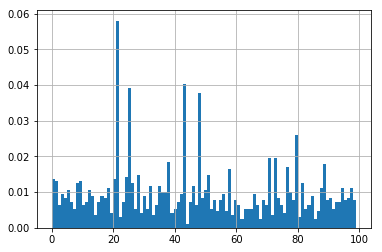

In [193]:
w = [1 / len(clusters)] * len(clusters)
pd.Series([c[0] for c in clusters]).hist(bins=100, weights=w)

In [216]:
dfTest = pd.DataFrame(columns=['Max Topic', 'Text'])
orig_test.index = range(len(orig_test))
dfTest['Max Topic'] = [c[0] for c in clusters]
dfTest['Text'] = [orig_test[i] for i in range(len(orig_test)) if len(ltest[i]) > 0]

"@Janik1968: @realDonaldTrump @SpeakerRyan Watched the Megan Kelly special and I must say..it was very well done on both their parts" 

Congratulations Jim Herman! We are all proud of you @TrumpGolf!
https://t.co/RuuTippjw1 

#HappyMothersDay!   

"@Crusade4Honesty:  @BornToBeGOP @megynkelly  Megan can not contain her bias, it's in every show, Fox owners Saudi Prince agnstT" 

Congratulations to @gohermie for winning the @ShellHouOpen. We are all proud of you @TNGCBedminster &amp; all @TrumpGolf clubs! Great going! 

"@DeepakS76435750: @realDonaldTrump congratulations from India" 

"@Cam: Reports are RNC has received +1 million postcards so far! If I get more info on ## I'll post @AnnCoulter https://t.co/yhyWihDdMq" 

"@SheriffClarke:  

Congratulations Jim Herman! We are all proud of you @TrumpGolf!  

STATEMENT IN RESPONSE TO PRESIDENT OBAMA'S FAILED LEADERSHIP:  

"@RepaloneLori: @realDonaldTrump @kirstiealley we love you and know you will do an awesome job! Saw you in bethpage !! 👏

109     None
132     None
206     None
431     None
488     None
616     None
659     None
848     None
1181    None
1368    None
1441    None
Name: Text, dtype: object

In [266]:
def testTopic(dfTest, i):
    group = dfTest[dfTest['Max Topic'] == i]['Text']
    group.apply(lambda x: print(x, "\n"))
    print("frequency:", len(group) / len(dfTest) * 100, "%")

# 98: media are biased
# 95: addressing Marco Rubio
# 1: Ted Cruz
# 2: ?
# 3: War, violence, terrorism, nuclear power..
# 4: Showing off Endorsements
# 5: ?
# 6: Team empowerement?
# 7: Trump Family is great
# 8: Cheating crooked hilary
# 9: Talking about fundings
# 10: Trump fights for people
# 11: ? Media 
# 12: Addressing workers
# 13: Trump president-elect
# 14: Trump "spreading the TRUTH"
# 15: Trump will win, the others will lose
# 16: All talk no action
# 17: Trump announces relocating
# 18: ? Nevada and Cruz again
# 19: ? Media?
# 20: Islamic terrorism ban
# 21: Trump thanking after rally
# 22: ? Hilary
# 23: Brexit
# 24: Discussing polls
# 25: Announcing interview
# 26: ? People supporting Trump
# 27: ?
# 28
testTopic(dfTest, 28)

Incompetent Hillary, despite the horrible attack in Brussels today, wants borders to be weak and open-and let the Muslims flow in.  No way! 

I will have set the all time record in primary votes in the Republican party --despite having to compete against 17 other people! 

If I only had 1 person running against me in the primaries like Hillary Clinton, I would have gotten 10 million more votes than she did! 

Are we talking about the same cyberattack where it was revealed that head of the DNC illegally gave Hillary the questions to the debate? 

Jeb Bush is desperate - strongly in favor of #CommonCore and very weak on illegal immigration. 

"@Elvisfan1976: @NRSC stop sending me emails asking me to donate and get a free DonaldTrump sticker. I support him and he's self funding! 

"@FreemarketSara: Trump's Historic 13 Million Primary Votes - A Record ... Congratulations @realDonaldTrump  

During the GOP convention, CNN cut away from the victims of illegal immigrant violence. They don’t w

In [255]:
lda.save(fname="LDAModel")

In [260]:
sv = pd.DataFrame()
sv['proc'] = ltest
sv['original text'] = orig_test

In [262]:
dfTest.to_csv("Test Sample.csv")

<h1>Roadmap to Milestone 3</h1>

This section contains all the tasks that we intend to complete for the 3rd milestone.